# Uncertainty-aware PNN model for cpu limits, number of clients, and model inference time
This is a script training a PNN model to predict the relationship among allocated cpu limits, number of clients, and model inference time
This script is based on the [example](https://colab.research.google.com/drive/1lbhwb6MP8FvQh9Q7Jldt4PuPEeSldsG5?usp=sharing) in the [Uncertainty Toolbox](https://github.com/uncertainty-toolbox/uncertainty-toolbox) repo.

In [1]:
# Imports
import random
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, TensorDataset

# Import Uncertainty Toolbox
import uncertainty_toolbox as uct

# Imports specifically for this tutorial.
from simple_uq.models.pnn import PNN
from simple_uq.util.synthetic_data import create_1d_data

In [2]:
# Set random seed
seed = 111
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# read data from  "data_points_lists.json"
import json
with open('data_points_lists.json', 'r') as f:
    data_points_lists = json.load(f)
cpu_list_read = data_points_lists['cpu_list']
num_clients_list_read = data_points_lists['num_clients_list']
model_time_list_read = data_points_lists['model_time_list']

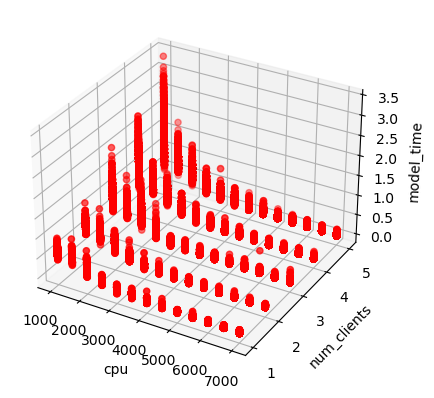

In [4]:
# visualize the data as a 3D plot
# x-axis: cpu
# y-axis: num_clients
# z-axis: model_time

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cpu_list_read, num_clients_list_read, model_time_list_read, c='r', marker='o')
ax.set_xlabel('cpu')
ax.set_ylabel('num_clients')
ax.set_zlabel('model_time')
plt.show()

In [5]:
# separate the data for different num_clients

# get all unique num_clients
num_clients_val_list = list(set(num_clients_list_read))
# create list of dictionaries
# each dictionary contains the data for one num_clients
# {'num_client': num_client_val, 'num_clients_list': [num_clients], 'cpu_list': [cpu], 'model_time_list': [model_time], 'number_of_data_points': number_of_data_points}
data_points_lists = []  
for num_clients_val in num_clients_val_list:
    data_points_dict = {}
    data_points_dict['num_clients_val'] = num_clients_val
    data_points_dict['num_clients_list'] = [num_clients_list_read[i] for i in range(len(num_clients_list_read)) if num_clients_list_read[i] == num_clients_val]
    data_points_dict['cpu_list'] = [cpu_list_read[i] for i in range(len(num_clients_list_read)) if num_clients_list_read[i] == num_clients_val]
    data_points_dict['model_time_list'] = [model_time_list_read[i] for i in range(len(num_clients_list_read)) if num_clients_list_read[i] == num_clients_val]
    assert len(data_points_dict['num_clients_list']) == len(data_points_dict['cpu_list']) == len(data_points_dict['model_time_list']), "lengths of lists are not equal"
    data_points_dict['number_of_data_points'] = len(data_points_dict['cpu_list'])
    print(data_points_dict['number_of_data_points'])
    data_points_lists.append(data_points_dict)


7800
15600
24000
31200
39000


In [6]:
# covert read lists to np arrays
cpu_list = np.array(cpu_list_read)
num_clients_list = np.array(num_clients_list_read)
model_time_list = np.array(model_time_list_read)

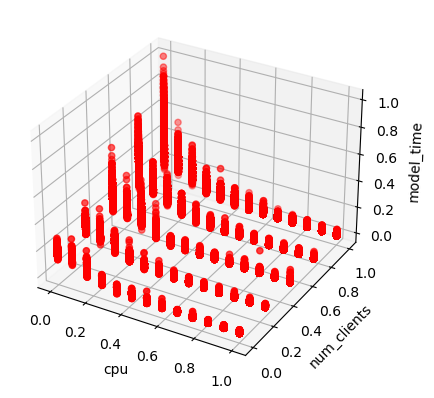

In [7]:
# normalize the data to [0,1]
min_cpu, max_cpu = min(cpu_list), max(cpu_list)
min_num_clients, max_num_clients = min(num_clients_list), max(num_clients_list)
min_model_time, max_model_time = min(model_time_list), max(model_time_list)
cpu_list_normalized = (cpu_list - min_cpu) / (max_cpu - min_cpu)
num_clients_list_normalized = (num_clients_list - min_num_clients) / (max_num_clients - min_num_clients)
model_time_list_normalized = (model_time_list - min_model_time) / (max_model_time - min_model_time)
# visualize the data as a 3D plot
# x-axis: cpu
# y-axis: num_clients
# z-axis: model_time
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cpu_list_normalized, num_clients_list_normalized, model_time_list_normalized, c='r', marker='o')
ax.set_xlabel('cpu')
ax.set_ylabel('num_clients')
ax.set_zlabel('model_time')
plt.show()

In [8]:
# concatenate the cpu_list_normalized and num_clients_list_normalized as xpts
xpts = np.concatenate((cpu_list_normalized.reshape(-1,1), num_clients_list_normalized.reshape(-1,1)), axis=1)
print(xpts.shape)
# let model_time_list_normalized be ypts
ypts = model_time_list_normalized.reshape(-1,1)
print(ypts.shape)

assert xpts.shape[0] == ypts.shape[0], "number of data points not equal"

(117600, 2)
(117600, 1)


In [9]:
# further divide the data into train, validation and test with ratio 8:1:1 by sampling evenly from the data
xpts_train = []
ypts_train = []
xpts_validation = []
ypts_validation = []
xpts_test = []
ypts_test = []

for idx in range(len(xpts)):
    if idx % 10 == 0:
        xpts_validation.append(xpts[idx])
        ypts_validation.append(ypts[idx])
    elif idx % 10 == 1:
        xpts_test.append(xpts[idx])
        ypts_test.append(ypts[idx])
    else:
        xpts_train.append(xpts[idx])
        ypts_train.append(ypts[idx])

In [10]:
# create dataloaders for train, validation and test
# convert the lists to np arrays
xpts_train = np.array(xpts_train)
ypts_train = np.array(ypts_train)
xpts_validation = np.array(xpts_validation)
ypts_validation = np.array(ypts_validation)
xpts_test = np.array(xpts_test)
ypts_test = np.array(ypts_test)

# convert the np arrays to tensors
xpts_train = torch.from_numpy(xpts_train).float()
ypts_train = torch.from_numpy(ypts_train).float()
xpts_validation = torch.from_numpy(xpts_validation).float()
ypts_validation = torch.from_numpy(ypts_validation).float()
xpts_test = torch.from_numpy(xpts_test).float()
ypts_test = torch.from_numpy(ypts_test).float()

# create TensorDatasets
train_dataset = TensorDataset(xpts_train, ypts_train)
validation_dataset = TensorDataset(xpts_validation, ypts_validation)
test_dataset = TensorDataset(xpts_test, ypts_test)

# create dataloaders
BATCH_SIZE = 16
NUM_WORKERS = 4
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# wrap the dataloaders in a dictionary
dataloaders = {
    "Train": train_dataloader,
    "Validation": validation_dataloader,
    "Test": test_dataloader,
}


## Train a Probabilistic Neural Network (PNN) model on the training data

To learn the conditional distribution Y|X, we will use a neural network model that outputs the mean and standard deviation of a Gaussian distribution (often called a Probabilistic Neural Net (PNN)). This model has been shown to have good performance, especially when ensembled ([Chua et al. 2018](https://arxiv.org/abs/1805.12114); [Lakshminarayanan et al. 2017](https://arxiv.org/abs/1612.01474)). However, the performance may suffer here since the true noise distribution is uniform instead of Gaussian. We will skip many of the details of the model and training since Uncertainty Toolbox is focused around model evaluation rather than model learning.

In [11]:
"""Make the PNN model."""
pnn = PNN(
    input_dim=2,
    output_dim=1,
    encoder_hidden_sizes=[64, 64],
    encoder_output_dim=64,
    mean_hidden_sizes=[],
    logvar_hidden_sizes=[],
)

In [12]:
"""Train the model with a pytorch-lightning trainer."""
trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=50, accelerator="gpu", devices="auto")
trainer.fit(pnn, dataloaders['Train'], dataloaders['Validation'])
# Get the test output.
test_results = trainer.test(pnn, dataloaders['Test'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type | Params
-------------------------------------
0 | encoder     | MLP  | 8.5 K 
1 | mean_head   | MLP  | 65    
2 | logvar_head | MLP  | 65    
-------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.035     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': -7.338179111480713}
--------------------------------------------------------------------------------


In [13]:
# save the model
torch.save(pnn, 'pnn_model.pt')
# save the state_dict
torch.save(pnn.state_dict(), 'pnn_model_state_dict.pt')

## Visualize Model Uncertainties

In [14]:
import matplotlib
from typing import Union, Tuple, List, Any, NoReturn

In [15]:
def filter_subset(input_list: List[List[Any]], n_subset: int) -> List[List[Any]]:
    """Keep only n_subset random indices from all lists given in input_list.

    Args:
        input_list: list of lists.
        n_subset: Number of points to plot after filtering.

    Returns:
        List of all input lists with sizes reduced to n_subset.
    """
    assert type(n_subset) is int
    n_total = len(input_list[0])
    idx = np.random.choice(range(n_total), n_subset, replace=False)
    idx = np.sort(idx)
    output_list = []
    for inp in input_list:
        outp = inp[idx]
        output_list.append(outp)
    return output_list

In [57]:

def plot_xy(
    y_pred: np.ndarray,
    y_std: np.ndarray,
    y_true: np.ndarray,
    x: np.ndarray,
    title_text: str = "Confidence Band",
    font_size: int = 25,
    n_subset: Union[int, None] = None,
    ylims: Union[Tuple[float, float], None] = None,
    xlims: Union[Tuple[float, float], None] = None,
    num_stds_confidence_bound: int = 2,
    leg_loc: Union[int, str] = 3,
    ax: Union[matplotlib.axes.Axes, None] = None,
) -> matplotlib.axes.Axes:
    """Plot one-dimensional inputs with associated predicted values, predictive
    uncertainties, and true values.

    Args:
        y_pred: 1D array of the predicted means for the held out dataset.
        y_std: 1D array of the predicted standard deviations for the held out dataset.
        y_true: 1D array of the true labels in the held out dataset.
        x: 1D array of input values for the held out dataset.
        n_subset: Number of points to plot after filtering.
        ylims: a tuple of y axis plotting bounds, given as (lower, upper).
        xlims: a tuple of x axis plotting bounds, given as (lower, upper).
        num_stds_confidence_bound: width of confidence band, in terms of number of
            standard deviations.
        leg_loc: location of legend as a str or legend code int.
        ax: matplotlib.axes.Axes object.

    Returns:
        matplotlib.axes.Axes object with plot added.
    """
    # Create ax if it doesn't exist
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,9))

    # Order points in order of increasing x
    order = np.argsort(x)
    y_pred, y_std, y_true, x = (
        y_pred[order],
        y_std[order],
        y_true[order],
        x[order],
    )

    # Optionally select a subset
    if n_subset is not None:
        [y_pred, y_std, y_true, x] = filter_subset([y_pred, y_std, y_true, x], n_subset)

    intervals = num_stds_confidence_bound * y_std
    
    
    # get average y_true for every x
    y_true_avg = []
    x_unique = np.unique(x)
    for x_val in x_unique:
        y_true_avg.append(np.mean(y_true[np.where(x == x_val)]))
    y_true_avg = np.array(y_true_avg)

    h1 = ax.plot(x, y_true, ".", mec="#ff7f0e", mfc="None")
    h2 = ax.plot(x_unique, y_true_avg, "-", c="#ff0000", linewidth=2)
    h3 = ax.plot(x, y_pred, "-", c="#1f77b4", linewidth=2)
    h4 = ax.fill_between(
        x,
        y_pred - intervals,
        y_pred + intervals,
        color="lightsteelblue",
        alpha=0.4,
    )
    ax.legend(
        [h1[0], h2[0], h3[0], h4],
        ["Observations", "Averages", "Predictions", "$95\%$ Interval"],
        loc=leg_loc,
        fontsize=font_size
    )

    # Format plot
    ax.xaxis.set_tick_params(labelsize=font_size)
    ax.yaxis.set_tick_params(labelsize=font_size)
    if ylims is not None:
        ax.set_ylim(ylims)

    if xlims is not None:
        ax.set_xlim(xlims)

    ax.set_xlabel("cpu limits ($m$)", fontsize = font_size)
    ax.set_ylabel("model inference time ($s$)", fontsize = font_size)
    ax.set_title(title_text, fontsize = font_size)
    ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable="box")

    return ax

In [64]:
def draw_95_ci(xpts_test, ypts_test, pnn, num_client_val):
    te_x, te_y = np.array(xpts_test), np.array(ypts_test)
    pred_mean, pred_std = pnn.get_mean_and_standard_deviation(te_x)
    pred_mean = pred_mean.flatten()
    pred_std = pred_std.flatten()
    # # compute the coverage of 95% interval
    # covered_count = 0
    # total_count = 0
    # intervals95 = 2 * pred_std 
    # for idx in range(0, len(te_x)):
    #     for te_y_pts in te_y:
    #         total_count += 1
    #         if te_y_pts >= pred_mean[idx] - intervals95[idx] and te_y_pts <= pred_mean[idx] + intervals95[idx]:
    #             covered_count += 1
    # print("coverage ", covered_count / total_count)

    # Plot confidence bands on test data
    te_x_dim1 = te_x[:, 0]
    # denormalize the data
    te_x_dim1 = te_x_dim1 * (max_cpu - min_cpu) + min_cpu
    te_y = te_y * (max_model_time - min_model_time) + min_model_time
    pred_mean = pred_mean * (max_model_time - min_model_time) + min_model_time
    pred_std = pred_std * (max_model_time - min_model_time) + min_model_time
    plot_xy(pred_mean, pred_std, te_y, te_x_dim1, title_text="Confidence Band For number of client = " + str(num_client_val), leg_loc="upper right", font_size=25)
    # plt.gcf().set_size_inches(4, 4)
    plt.tight_layout()
    plt.savefig('cpu_limit_model_time_vary_num_clients=' + str(num_client_val) + '.png')
    plt.show()

5
(7800, 2)
xpts test sample [[0.58333333 0.58333333 0.58333333 0.58333333 0.58333333 0.58333333
  0.58333333 0.58333333 0.58333333 0.58333333]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]
(7800, 1)


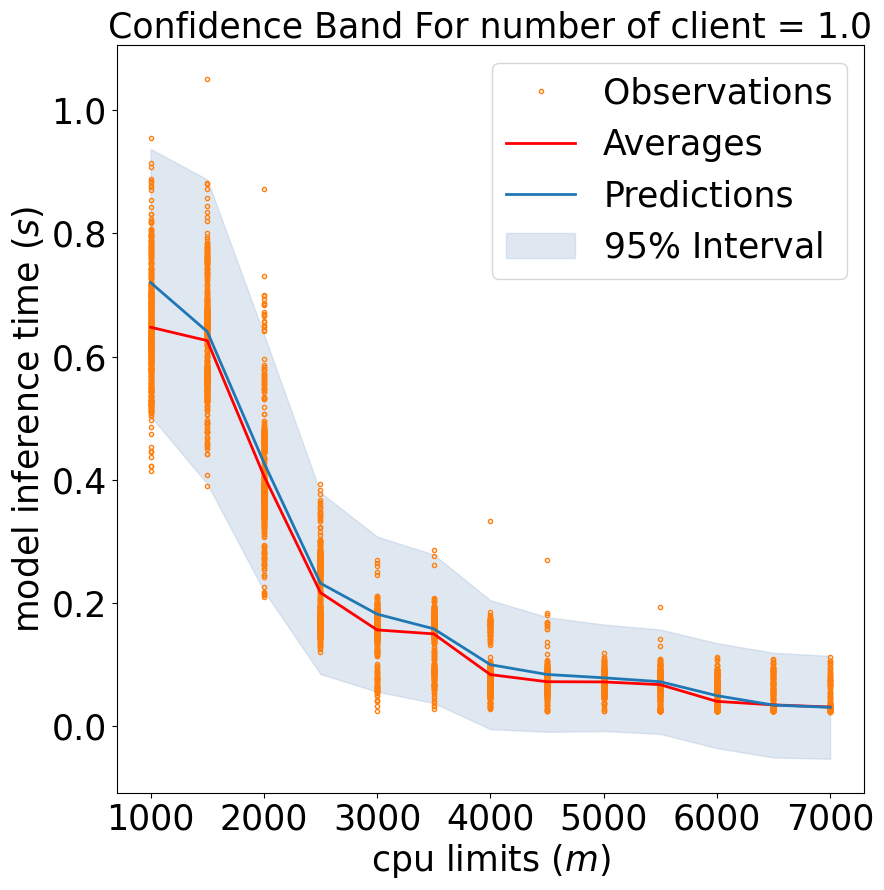

(15600, 2)
xpts test sample [[0.91666667 0.91666667 0.91666667 0.91666667 0.91666667 0.91666667
  0.91666667 0.91666667 0.91666667 0.91666667]
 [0.25       0.25       0.25       0.25       0.25       0.25
  0.25       0.25       0.25       0.25      ]]
(15600, 1)


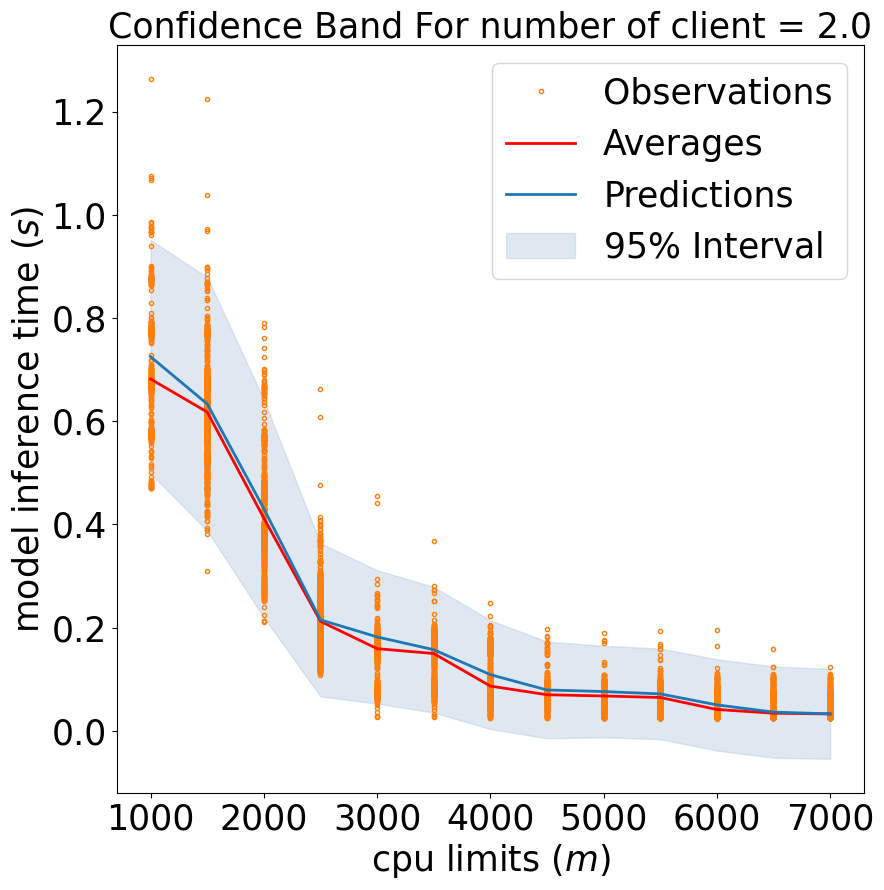

(24000, 2)
xpts test sample [[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
  0.16666667 0.16666667 0.16666667 0.16666667]
 [0.5        0.5        0.5        0.5        0.5        0.5
  0.5        0.5        0.5        0.5       ]]
(24000, 1)


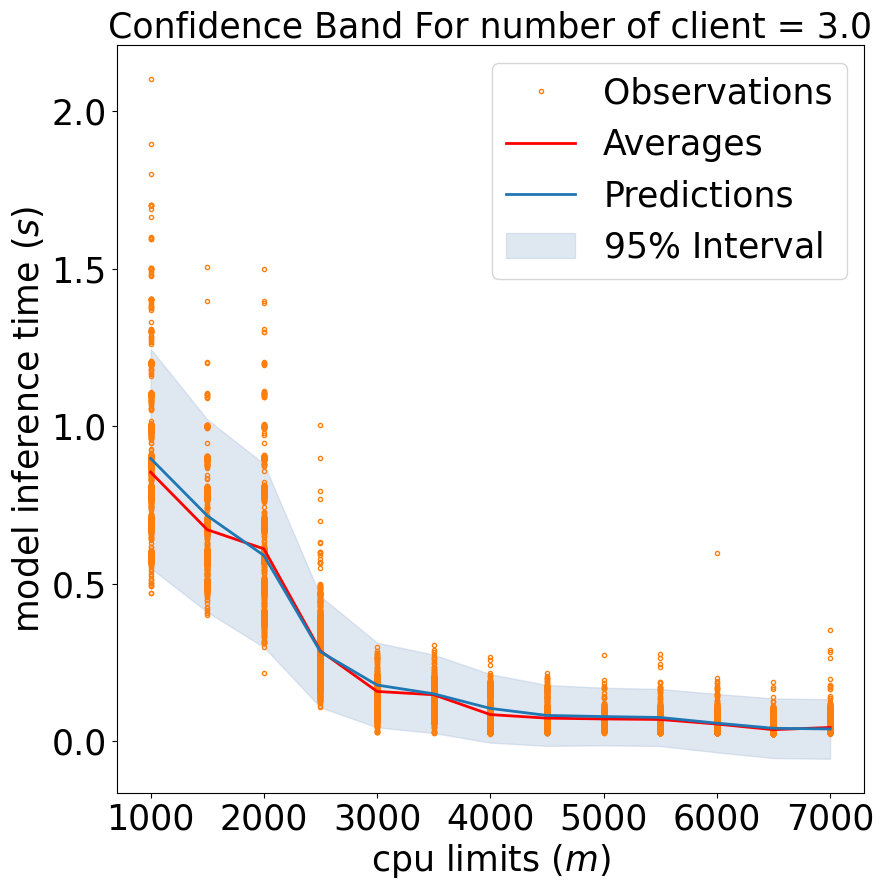

(31200, 2)
xpts test sample [[0.83333333 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333
  0.83333333 0.83333333 0.83333333 0.83333333]
 [0.75       0.75       0.75       0.75       0.75       0.75
  0.75       0.75       0.75       0.75      ]]
(31200, 1)


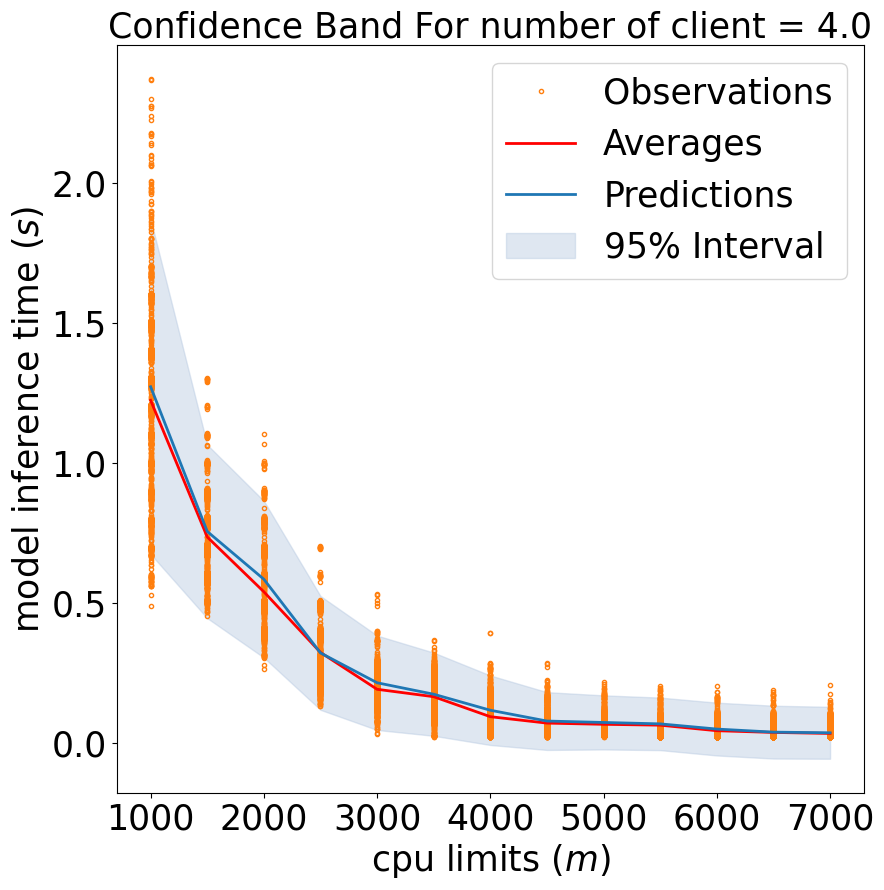

(39000, 2)
xpts test sample [[0.83333333 0.83333333 0.83333333 0.83333333 0.83333333 0.83333333
  0.83333333 0.83333333 0.83333333 0.83333333]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]]
(39000, 1)


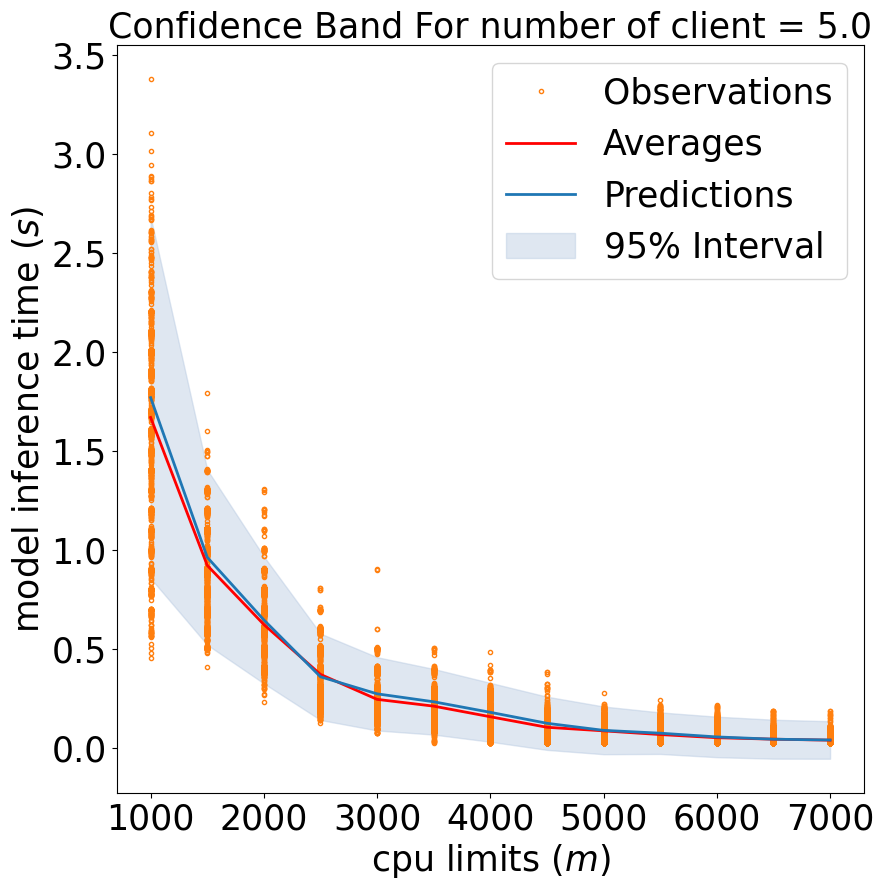

In [65]:
# we split the test array according to different num_clients
print(len(data_points_lists))
for data_point_dict in data_points_lists:
    cpu_list = data_point_dict['cpu_list']
    cpu_list = np.array(cpu_list)
    num_clients_list = data_point_dict['num_clients_list']
    num_clients_list = np.array(num_clients_list)
    model_time_list = data_point_dict['model_time_list']
    model_time_list = np.array(model_time_list)
    num_clients_val = data_point_dict['num_clients_val']
    # normalize the data to [0,1]
    cpu_list_normalized = (cpu_list - min_cpu) / (max_cpu - min_cpu)
    num_clients_list_normalized = (num_clients_list - min_num_clients) / (max_num_clients - min_num_clients)
    model_time_list_normalized = (model_time_list - min_model_time) / (max_model_time - min_model_time)
    # concatenate the cpu_list_normalized and num_clients_list_normalized as xpts
    xpts_test = np.concatenate((cpu_list_normalized.reshape(-1,1), num_clients_list_normalized.reshape(-1,1)), axis=1)
    ypts_test = model_time_list_normalized.reshape(-1,1)
    print(xpts_test.shape)
    print("xpts test sample", xpts_test[0:10].T)
    print(ypts_test.shape)
    # draw 95% confidence interval
    draw_95_ci(xpts_test, ypts_test, pnn, num_clients_val)